In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import os
from itertools import chain
import numpy as np
import glob

lines = ["b", "g", "r", "orange", "purple"]
colors1 = sns.color_palette("hls", 8)
colors2 = sns.color_palette("husl", 8)
markers = ["*", "s", "^", "o"]

In [2]:
def get_algorithm(params_path):
    with open(params_path, "r") as f:
        params = []
        for i, l in enumerate(f.readlines()):
            params.append(l)
    # get params
    ssl = [j.split(" ")[1].strip("\n") for j in params if "ssl_task" in j][0]
    return ssl

In [3]:
# cifar10
b256_fs = glob.glob("/home/noah/ESSL/final_exps/optimization/exp8*/*")
b256 = [os.path.join(f, "outcomes.json") for f in b256_fs]
b256_names = [get_algorithm(os.path.join(f, "params.txt")) for f in b256_fs]

b32_fs = glob.glob("/home/noah/ESSL/final_exps/optimization/exp6*/*")
b32 = [os.path.join(f, "outcomes.json") for f in b32_fs]
b32_names = [get_algorithm(os.path.join(f, "params.txt")) for f in b32_fs]

# SVHN
b256_fs_svhn = glob.glob("/home/noah/ESSL/final_exps/optimization/exp10*/*")
b256_svhn = [os.path.join(f, "outcomes.json") for f in b256_fs_svhn]
b256_names_svhn = [get_algorithm(os.path.join(f, "params.txt")) for f in b256_fs_svhn]

b32_fs_svhn = glob.glob("/home/noah/ESSL/final_exps/optimization/exp11*/*")
b32_svhn = [os.path.join(f, "outcomes.json") for f in b32_fs_svhn]
b32_names_svhn = [get_algorithm(os.path.join(f, "params.txt")) for f in b32_fs_svhn]


In [4]:
def plot_exp(exp_names, exps, title, metric, baseline=True):
    for i, (exp, exp_path) in enumerate(zip(exp_names, exps)):
        with open(exp_path, "r") as f:
            results = json.load(f)        
        plt.plot(range(1, len(results[metric])+1), results[metric], color=colors2[i], linestyle="-", marker=markers[i], label=f"{exp}")
    if baseline:
        plt.plot(range(1, len(results[metric])+1), [83.01 for _ in range(len(results[metric]))], color="black", linestyle=":", label="Supervised")    
    plt.xlabel("Generation")
    plt.ylabel("Test Accuracy")
    plt.xticks=(range(len(results[metric])))
    plt.legend(bbox_to_anchor=(1.5, 1.02))
    plt.suptitle(title)
    plt.show() 
    plt.clf()

def plot_exp_on_ax(exp_names, exps, title, metric, ax):
    for i, (exp, exp_path) in enumerate(zip(exp_names, exps)):
        with open(exp_path, "r") as f:
            results = json.load(f)        
        ax.plot(range(1, len(results[metric])+1), results[metric], color=colors2[i], linestyle="-", marker=markers[i], label=f"{exp}")

    ax.plot(range(1, len(results[metric])+1), [83.01 for _ in range(len(results[metric]))], color="black", linestyle=":", label="Supervised")    
    ax.xticks=(range(len(results[metric])))
    ax.set_title(title)

def get_data_from_dir(exp_dir):
    # get op, int format data from exp_dir
    exps = glob.glob(os.path.join(exp_dir, "*/"))
    chromos = []
    for e in exps:
        seed = e.split("/")[-2]
        with open(os.path.join(e, "outcomes.json"), "r") as f:
            results = json.load(f)
            for fitness, chromo in zip(results["pop_vals"], results["chromos"]):
                c = list(chain.from_iterable(chromo[1]))
                c.append(seed)
                c.append(fitness[1])
                chromos.append(c)
    columns = list(chain.from_iterable([[f"aug{i}", f"op{i}"] for i in range(1, 4)]))
    columns.append("seed")
    columns.append("test acc")
    columns
    df = pd.DataFrame(chromos, columns=columns)
    
    # create data in long format
    ops = set(list(df["aug1"]) + list(df["aug2"]) +  list(df["aug3"]))
    indexes = {op:i for i, op in enumerate(ops)}
    chromos_long = np.zeros([len(chromos), len(ops)+2])
    for i, c in enumerate(chromos):
        for aug, intensity in zip(c[:-2][::2], c[:-2][1::2]):
            chromos_long[i][indexes[aug]] = intensity
            chromos_long[i][-2] = int(c[-2])
            chromos_long[i][-1] = c[-1]
    columns_long = list(ops) + ["seed", "fitness"]
    df_long = pd.DataFrame(chromos_long, columns = columns_long)
    return df, df_long, ops

def get_data(exp_path):
    chromos = []
    with open(exp_path, "r") as f:
        results = json.load(f)
        for fitness, chromo in zip(results["pop_vals"], results["chromos"]):
            c = list(chain.from_iterable(chromo[1]))
            c.append(fitness[1])
            chromos.append(c)
    columns = list(chain.from_iterable([[f"aug{i}", f"op{i}"] for i in range(1, 4)]))
    columns.append("test acc")
    columns
    df = pd.DataFrame(chromos, columns=columns)
    
    # create data in long format
    ops = set(list(df["aug1"]) + list(df["aug2"]) +  list(df["aug3"]))
    indexes = {op:i for i, op in enumerate(ops)}
    chromos_long = np.zeros([len(chromos), len(ops)+1])
    for i, c in enumerate(chromos):
        for aug, intensity in zip(c[:-2][::2], c[:-2][1::2]):
            chromos_long[i][indexes[aug]] = intensity
            chromos_long[i][-1] = c[-1]
    columns_long = list(ops) + ["fitness"]
    df_long = pd.DataFrame(chromos_long, columns = columns_long)
    return df, df_long, ops

def gen_palette(all_exps):
    total_dfs = []
    for e in all_exps:
        df, df_long, ops = get_data(e)
        df = df.drop(columns=["op1", "op2", "op3"])
        df.columns= ["op1", "op2", "op3", "test acc"]
        total_dfs.append(df)
    
    full_df = pd.concat(total_dfs)
    ops = set(list(full_df["op1"].unique()) + list(full_df["op2"].unique()) + list(full_df["op3"].unique()))
    palette = {op:c for op, c in zip(ops, sns.color_palette("hls", len(ops)))}
    return palette
PALETTE = gen_palette(b32+b256+b32_svhn+b256_svhn)

In [5]:
def operator_importance(path, method, N=50):
    df, df_long, ops = get_data(path)
    df = df.drop(columns=["op1", "op2", "op3"])
    df.columns= ["op1", "op2", "op3", "test acc"]
    df = df.sort_values(by="test acc", ascending=False)
    counts = []
    both = []
    for op in ops:
        c = (df["op1"] == op)[:N].sum() + (df["op2"] == op)[:N].sum() + (df["op3"] == op)[:N].sum()
        counts.append(c)
        both.append([op, c])
    a = [x[1] for x in both]
    both.sort(key=lambda x: x[1], reverse=True)
    both = [[i[0], (float(i[1])-min(a))/(max(a)-min(a))] for i in both]
    palette = [PALETTE[op] for op, _ in both]

    sns.barplot(x=[i[1] for i in both], y=[i[0] for i in both], palette=palette)
    plt.suptitle(f"op importance, {method}")
    plt.show()
    plt.clf()


SimSiam


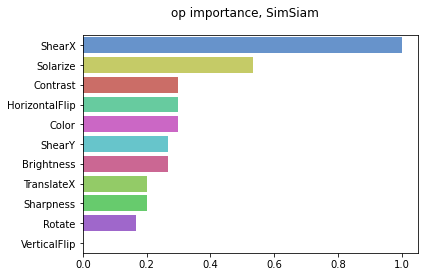

BYOL


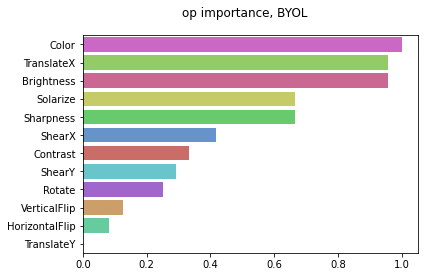

NNCLR


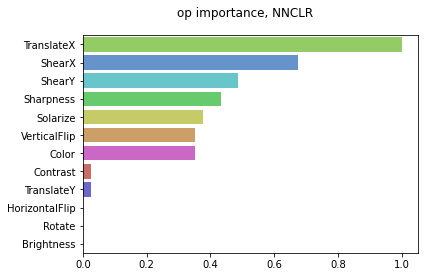

SwaV


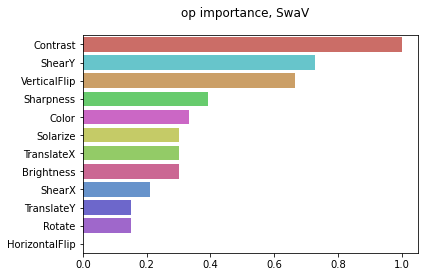

<Figure size 432x288 with 0 Axes>

In [6]:
# b32 Cifar10 
for path, name in zip(b32, b32_names):
    print(name)
    operator_importance(path=path, method=name)

NNCLR


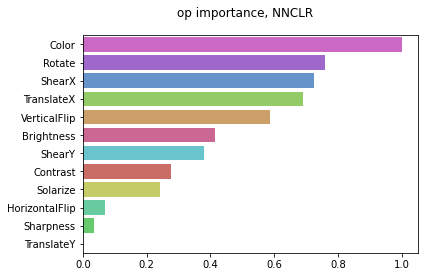

SimSiam


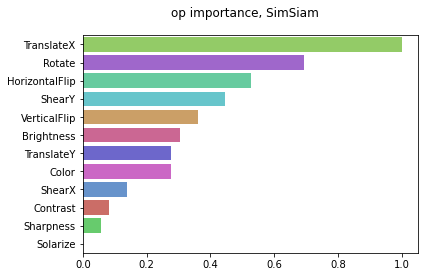

BYOL


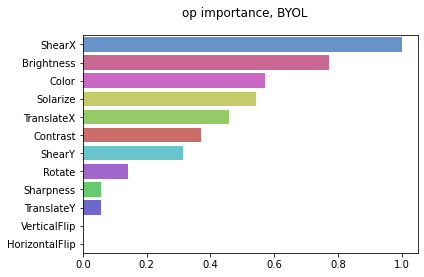

SwaV


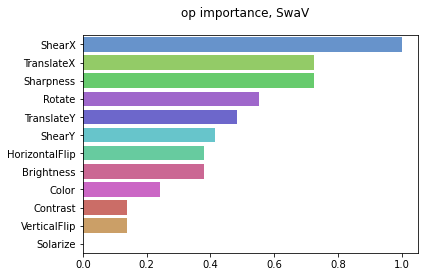

<Figure size 432x288 with 0 Axes>

In [7]:
# b256 Cifar10
for path, name in zip(b256, b256_names):
    print(name)
    operator_importance(path=path, method=name)

SwaV


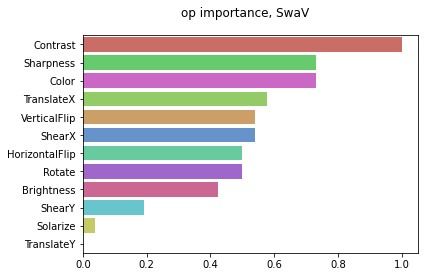

NNCLR


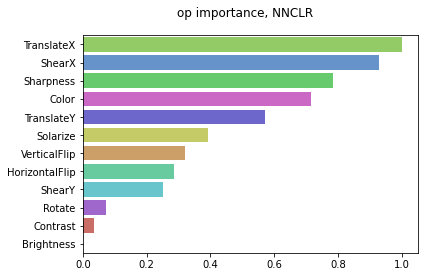

SimSiam


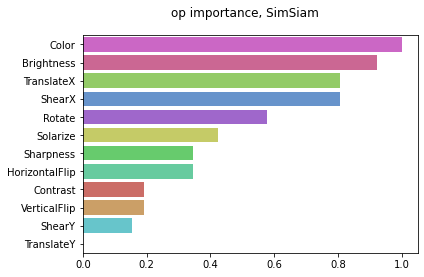

BYOL


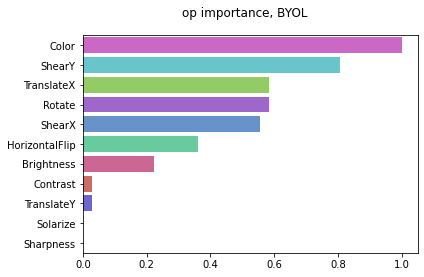

<Figure size 432x288 with 0 Axes>

In [8]:
# b32 SVHN 
for path, name in zip(b32_svhn, b32_names_svhn):
    print(name)
    operator_importance(path=path, method=name)

NNCLR


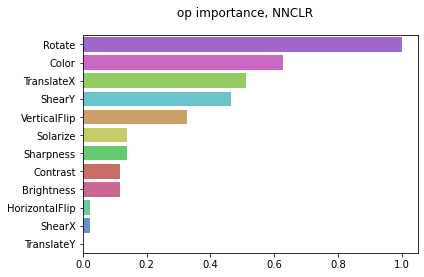

SwaV


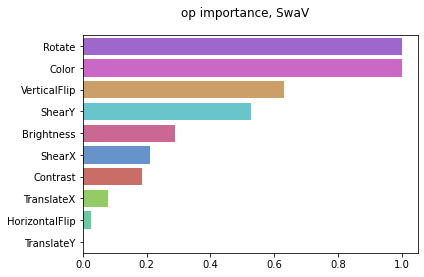

BYOL


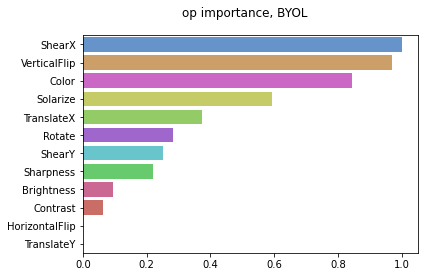

SimSiam


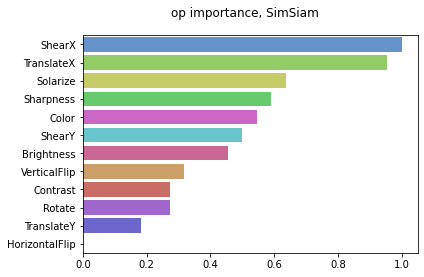

<Figure size 432x288 with 0 Axes>

In [9]:
# b256 SVHN
for path, name in zip(b256_svhn, b256_names_svhn):
    print(name)
    operator_importance(path=path, method=name)

In [10]:
def operator_sensitivity(path, method):
    df, df_long, all_ops = get_data(path)
    chromo_df = df.drop(columns=["op1", "op2", "op3"])
    chromo_df.columns= ["op1", "op2", "op3", "test acc"]
    chromo_df["chromosome"] = [" ".join(ops) for ops in zip(chromo_df["op1"], chromo_df["op2"], chromo_df["op3"])]
    chromo_df = chromo_df.sort_values(by="test acc", ascending=False)
    # treating order as not important
    cols = ["op1", 
            "op2",
            "op3", ]
    total_similar_accs = {}
    total_similar_chromos = {}
    for op in all_ops:
        
        op_df = chromo_df[(chromo_df[cols]==op).any(axis="columns")]
        similar_accs = []
        similar_chromos = []
        for i, row_i in op_df.iterrows():
            p_i = row_i["test acc"]
            similar_chromos_i = [row_i["chromosome"]]
            # determine which operator contains the gene
            if row_i["op1"] == op:
                operator = "op1"
            if row_i["op2"] == op:
                operator = "op2"
            if row_i["op3"] == op:
                operator = "op3"
            # list of operators that are not op
            other_cols = list(set(cols) - set([operator]))
            avg = 0
            num = 0
            for k, row_k in chromo_df.iterrows():
                if i == k:
                    continue
                if (row_i[operator] not in list(row_k[["op1", "op2", "op3"]])) and \
                (row_i[other_cols[0]] in list(row_k[["op1", "op2", "op3"]])) and \
                (row_i[other_cols[1]] in list(row_k[["op1", "op2", "op3"]])):
                    avg+=row_k["test acc"]
                    num+=1
                    similar_chromos_i.append(row_k["chromosome"])
            if num == 0:
                continue
            similar_accs.append(abs(p_i - (avg/num)))
            similar_chromos.append(similar_chromos_i)
        total_similar_accs[op] = similar_accs
        total_similar_chromos[op] = similar_chromos
    avg_accs = []
    avg_ops = []
    both = []
    missing = []
    for i, op in enumerate(total_similar_accs):
        try:
            avg_accs.append(sum(total_similar_accs[op])/len(total_similar_accs[op]))
            avg_ops.append(op)
            both.append([op, sum(total_similar_accs[op])/len(total_similar_accs[op])])
        except:
            missing.append(op)
    a = [x[1] for x in both]
    both.sort(key=lambda x: x[1], reverse=True)
    both = [[i[0], (float(i[1])-min(a))/(max(a)-min(a))] for i in both]
    palette = [PALETTE[op] for op, _ in both]
    sns.barplot(y=[x[0] for x in both], x=[x[1] for x in both], palette=palette)
    plt.suptitle(f"op sensitivity, {method}")
    plt.show()
    plt.clf()

SimSiam


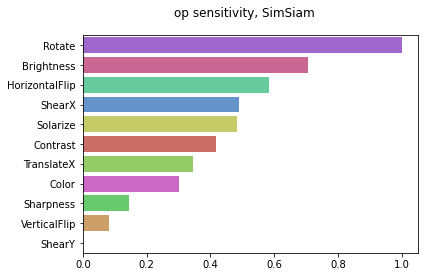

BYOL


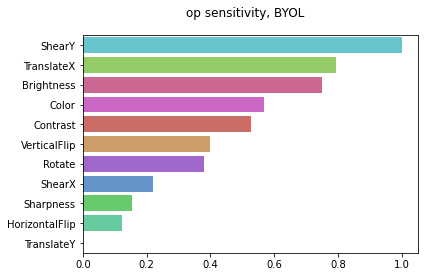

NNCLR


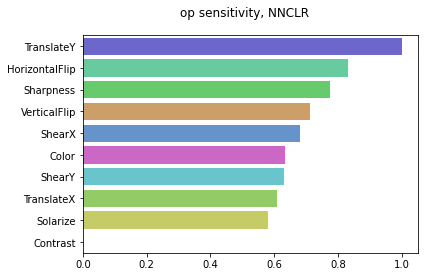

SwaV


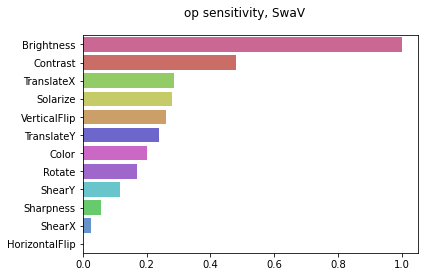

<Figure size 432x288 with 0 Axes>

In [11]:
# b32 Cifar10
for path, name in zip(b32, b32_names):
    print(name)
    operator_sensitivity(path, name)

NNCLR


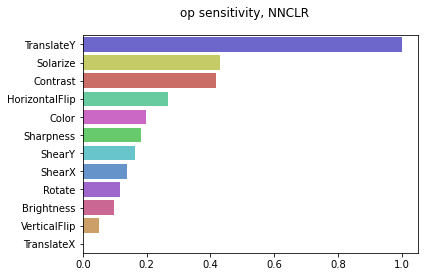

SimSiam


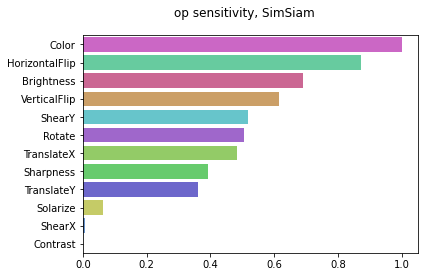

BYOL


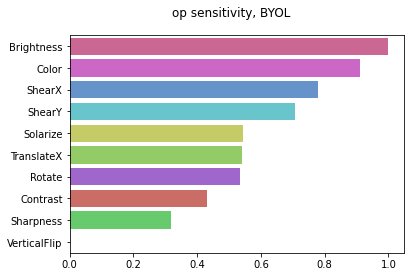

SwaV


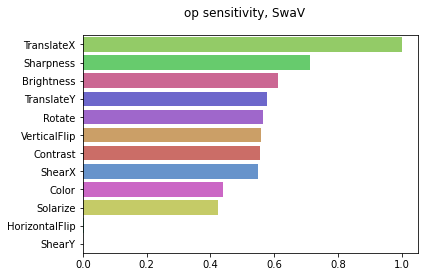

<Figure size 432x288 with 0 Axes>

In [12]:
# b256 Cifar10
for path, name in zip(b256, b256_names):
    print(name)
    operator_sensitivity(path, name)

SwaV


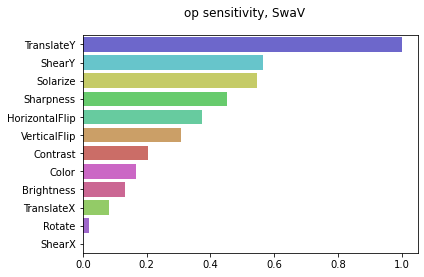

NNCLR


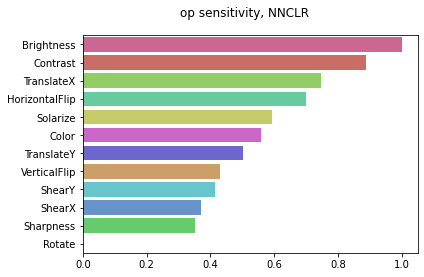

SimSiam


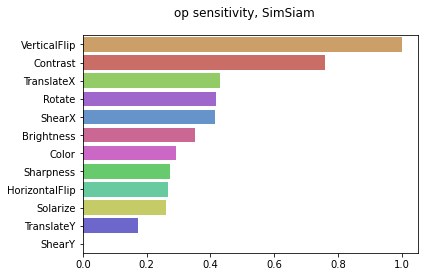

BYOL


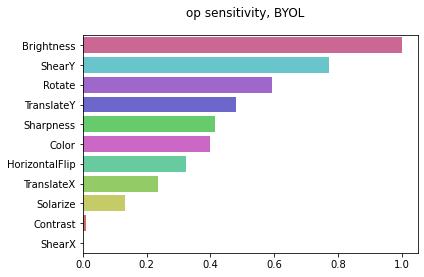

<Figure size 432x288 with 0 Axes>

In [13]:
# b32 SVHN
for path, name in zip(b32_svhn, b32_names_svhn):
    print(name)
    operator_sensitivity(path, name)

NNCLR


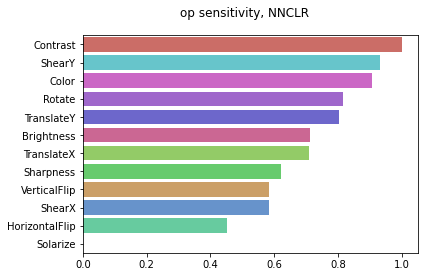

SwaV


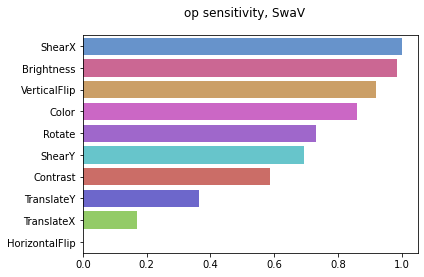

BYOL


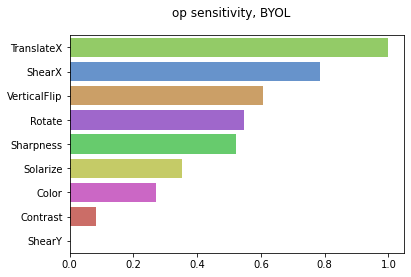

SimSiam


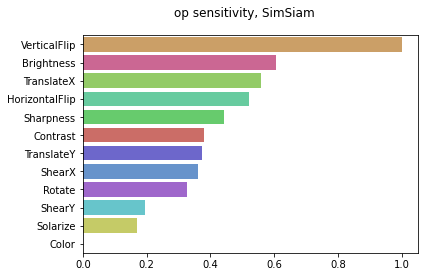

<Figure size 432x288 with 0 Axes>

In [14]:
# b256 SVHN
for path, name in zip(b256_svhn, b256_names_svhn):
    print(name)
    operator_sensitivity(path, name)

In [11]:
import torchvision
import PIL
from essl import ops
def get_best_chromo(path, name):
    df, df_long, all_ops = get_data(path)
    # chromo_df = df.drop(columns=["op1", "op2", "op3"])
    #chromo_df.columns= ["op1", "op2", "op3", "test acc"]
   # chromo_df["chromosome"] = [" ".join(ops) for ops in zip(chromo_df["op1"], chromo_df["op2"], chromo_df["op3"])]
    df = df.sort_values(by="test acc")
    return [[df.iloc[-1][f'aug{i}'], df.iloc[-1][f'op{i}']] for i in range(1, 4)]

def gen_augmentation_PIL(chromosome: list) -> torchvision.transforms.Compose:
    # gen augmentation
    # dataloader(augmentation)
    aug = torchvision.transforms.Compose([
        torchvision.transforms.Lambda(ops.__dict__[op](intensity=i))
        for op, i in chromosome
    ])
    return aug

def visualize_chromosome(save_path, chromosome):
    cifar10 = torchvision.datasets.CIFAR10("datasets/cifar10", download=True)
    sample = PIL.Image.fromarray(cifar10.data[7])
    sample.save(os.path.join(save_path, "original.jpg"))

    for i in range(num_samples):
        cc = c()
        aug = gen_augmentation_PIL(cc)
        augmented_im = aug(sample)
        augmented_im.save(os.path.join(save_path, f"{i}.jpg"))
    df = pd.DataFrame(chromosomes, columns=[f"op{i}" for i in range(len(chromosomes[0]))])
    df.to_csv(os.path.join(save_path, "chromosomes.csv"))

In [14]:
from  essl import ops
chromos = []
save_path = "/home/noah/ESSL/PAPER/figures/vis_augs"
cifar10 = torchvision.datasets.CIFAR10("datasets/cifar10", download=True)
sample = PIL.Image.fromarray(cifar10.data[7])
sample.save(os.path.join(save_path, "original.jpg"))
# b32 Cifar10
for path, name in zip(b32, b32_names):
    chromos.append(get_best_chromo(path, name))
    print(name)
    best_c = get_best_chromo(path, name)
    aug = gen_augmentation_PIL(best_c)
    augmented_im = aug(sample)
    augmented_im.save(os.path.join(save_path, f"{name}_bs32_c10.jpg"))

Files already downloaded and verified
SimSiam
BYOL
NNCLR
SwaV
